PART 1 对每个病人，读取 CT 图像和 segmentation mask，
自动对齐 Z 坐标并裁剪，
得到 image_3d 和 mask_3d，用于提 ROI 特征。

In [17]:
import os, pydicom, numpy as np, SimpleITK as sitk

# 从一个 DICOM 文件夹读取为 3D 图像（SimpleITK 对象）
def read_dicom_series(folder_path):
    reader = sitk.ImageSeriesReader()
    dicom_names = reader.GetGDCMSeriesFileNames(folder_path)
    reader.SetFileNames(dicom_names)
    return reader.Execute()

# 从 segmentation 文件中提取它引用的 CT 图像的 Series UID
def get_series_uid_from_seg(seg_path):
    return pydicom.dcmread(seg_path).ReferencedSeriesSequence[0].SeriesInstanceUID

# 递归查找给定目录下，是否有某个 .dcm 文件的 SeriesInstanceUID 与目标 UID 匹配
def find_ct_folder_by_uid(folder, uid):
    for root, _, files in os.walk(folder):
        for f in files:
            if f.lower().endswith(".dcm"):
                try:
                    if pydicom.dcmread(os.path.join(root, f), stop_before_pixels=True).SeriesInstanceUID == uid:
                        return root
                except: continue
    return None

# 计算 3D 图像中每一层的真实空间 Z 坐标，考虑方向矩阵、origin 和 spacing
def get_z_coords(sitk_img):
    sz, sp, org, dir3 = sitk_img.GetSize(), sitk_img.GetSpacing(), sitk_img.GetOrigin(), sitk_img.GetDirection()
    return [org[2] + i * sp[2] * dir3[8] for i in range(sz[2])]

# 将 segmentation 图像中 Z 坐标不在 CT 图中的那部分切掉，确保两者的 Z 层匹配
def align_segmentation_by_z(seg_img, seg_z, ct_z):
    zset = set(round(z, 1) for z in ct_z)
    return sitk.GetArrayFromImage(seg_img)[[i for i, z in enumerate(seg_z) if round(z, 1) in zset]]

# 将 CT 或 segmentation 图像重采样（resample）为统一 spacing（默认 1mm³），保证空间尺度一致。
def resample_to_spacing(image_sitk, new_spacing=(1.0, 1.0, 1.0), interpolator=sitk.sitkLinear):
    original_spacing = image_sitk.GetSpacing()
    original_size = image_sitk.GetSize()
    new_size = [
        int(round(original_size[i] * (original_spacing[i] / new_spacing[i])))
        for i in range(3)
    ]
    resampler = sitk.ResampleImageFilter()
    resampler.SetOutputSpacing(new_spacing)
    resampler.SetSize(new_size)
    resampler.SetOutputDirection(image_sitk.GetDirection())
    resampler.SetOutputOrigin(image_sitk.GetOrigin())
    resampler.SetInterpolator(interpolator)
    return resampler.Execute(image_sitk)

# 裁剪HU值范围并归一化到[0,1] (rescale)
def normalize_gray(image_np, clip_range=(-1000, 400)):
    image_np = np.clip(image_np, *clip_range)
    return (image_np - clip_range[0]) / (clip_range[1] - clip_range[0])

# 主函数：找到并读取CT和segmentation，resample,对齐z坐标，归一化灰度
def load_aligned_ct_and_mask(patient_folder, target_spacing=(1.0, 1.0, 1.0)):
    seg_path = next((os.path.join(root, f) for root, _, files in os.walk(patient_folder)
                     for f in files if "segmentation" in root.lower() and f.endswith(".dcm")), None)
    if not seg_path: return None, None, None

    uid = get_series_uid_from_seg(seg_path)
    ct_folder = find_ct_folder_by_uid(patient_folder, uid)
    if not ct_folder: return None, None, None

    # CT 和 segmentation 原始图像
    ct_img = read_dicom_series(ct_folder)
    seg_img = sitk.ReadImage(seg_path)

    # Resample to same spacing (1mm)
    ct_img = resample_to_spacing(ct_img, new_spacing=target_spacing)
    
    # 用 CT 图作为参考，resample segmentation
    resampler = sitk.ResampleImageFilter()
    resampler.SetReferenceImage(ct_img)
    resampler.SetInterpolator(sitk.sitkNearestNeighbor)
    seg_img = resampler.Execute(seg_img)

    # Z 坐标对齐
    ct_z = get_z_coords(ct_img)
    seg_z = get_z_coords(seg_img)
    mask = align_segmentation_by_z(seg_img, seg_z, ct_z)

    image = sitk.GetArrayFromImage(ct_img)
    image = normalize_gray(image)

    # 最终输出
    return image, mask, target_spacing

In [18]:
image, mask, spacing = load_aligned_ct_and_mask("../testdata/dataset1/LUNG1-001")

if image is not None:
    roi = image * (mask > 0)
    print("ROI volume shape:", roi.shape)


ROI volume shape: (402, 500, 500)


In [20]:
import os

base_dir = "../testdata/dataset1"

for patient_id in sorted(os.listdir(base_dir)):
    patient_path = os.path.join(base_dir, patient_id)
    if not os.path.isdir(patient_path):
        continue  # 跳过非文件夹

    image, mask, spacing = load_aligned_ct_and_mask(patient_path)

    if image is not None:
        roi = image * (mask > 0)
        print(f"{patient_id} ROI volume shape: {roi.shape}")
        # TODO: 可在这里添加特征提取、保存截图、收集 CSV 数据等
    else:
        print(f"{patient_id} 无法加载或对齐")

LUNG1-001 ROI volume shape: (402, 500, 500)
LUNG1-002 ROI volume shape: (333, 500, 500)


254


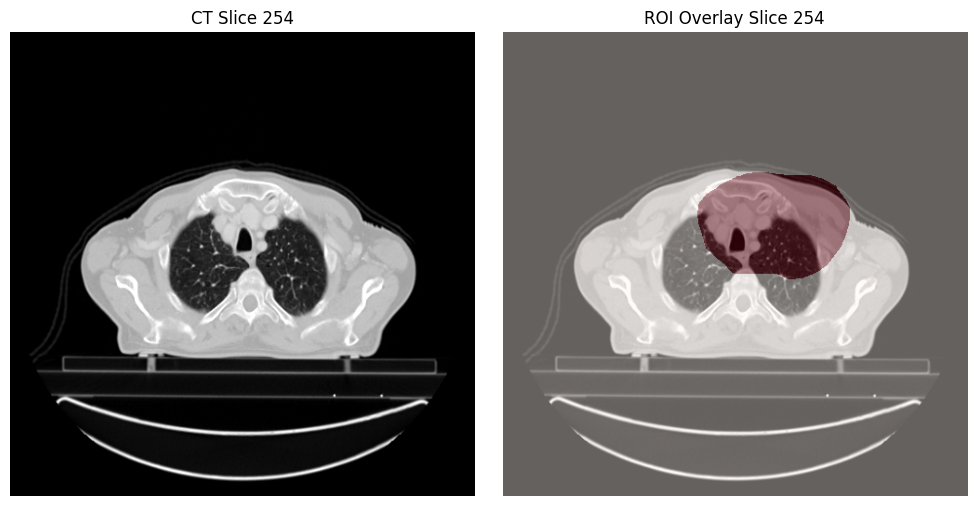

In [21]:
slice_idx = np.argmax(np.sum(mask, axis=(1, 2)))  # 找出掩膜最大的一层
print(slice_idx)
show_ct_with_mask_overlay(image, mask, slice_idx)
